This jupyter notebook provides an example of how two series of values that have very low correlation scores (and have no reason to be correlated), can have seemingly high measures of correlation if there is an arbitary trend occuring over the series.

Any set of observations of values, that are measured at discrete intervals in time can be reffered to as a time series. We will use the term time series in this appendix.


#### Import libraries

In [1]:
import numpy as np
import pandas as pd
from numpy.random import random_sample
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

# Correlations between two random lists of measurements

#### creating two sets of random values: a & b.

a & b can be thought of as individual time series.

In [2]:
i = 70 # number of points to create
np.random.seed(6) # set seed for random generation: so produces the same random sample for 
rand = pd.DataFrame({'a': np.random.randn(i),'b':np.random.randn(i)})
rand['a'] = rand['a'] + 5
rand['b'] = rand['b'] + 1

Showing the first 5 points in each timeseries:

In [3]:
rand.head()

,a,b
0,4.688216,1.951201
1,5.729004,1.441897
2,5.217821,2.469017
3,4.100908,2.749516
4,2.513219,1.353531


Plot points in each time series

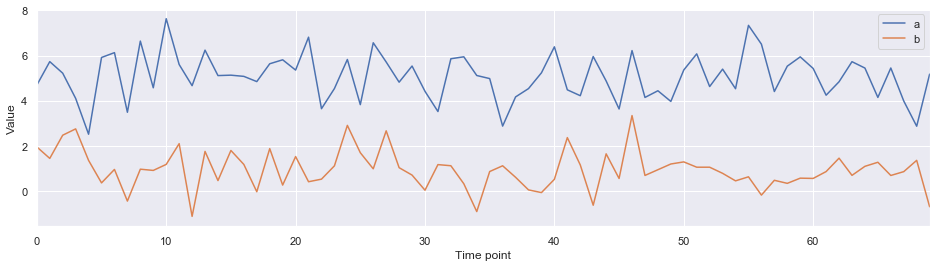

In [4]:
fig, ax = plt.subplots();
rand.plot(figsize=(16,4),ax=ax);
ax.legend(frameon=True);
ax.set_ylabel('Value');
ax.set_xlabel('Time point');

Calculating the pearson correlation between the values in each time series: we find there is low/no correlation (-0.001) between a & b.

In [5]:
# calc correlation matrix
rand.corr('pearson').round(3)

,a,b
a,1.000,-0.001
b,-0.001,1.000


# Adding an arbitrary linear upward trend to each time series...

In [6]:
rand['a_with_trend'] = rand.a + rand.index/10

In [7]:
rand['b_with_trend'] = rand.b + rand.index/15

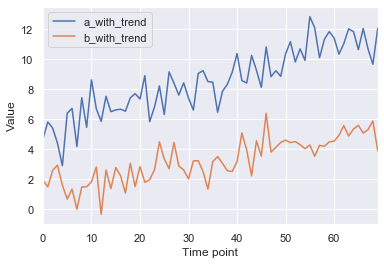

In [8]:
fig, ax = plt.subplots();
rand[['a_with_trend','b_with_trend']].plot(ax=ax);
ax.legend(frameon=True);
ax.set_ylabel('Value');
ax.set_xlabel('Time point');

In [9]:
# calc correlation matrix
rand.corr('pearson').round(2)

,a,b,a_with_trend,b_with_trend
a,1.00,-0.00,0.39,-0.08
b,-0.00,1.00,-0.19,0.40
a_with_trend,0.39,-0.19,1.00,0.72
b_with_trend,-0.08,0.40,0.72,1.00


We observe the spearman rank correlation coefficient between each list with added trend (a_with_trend & b_with_trend) is much greater (0.72).

# Removing the trend in the time series

We fit a polynomial to each series: y = mx + c . We remove the trend by subtracting the polynomial.

In [10]:
def func_dtoc(x, m, c):
    return (m * x)  + c

In [11]:
def detrend_using_func(dta,column,func,ylabel,color='b'):
    
    #### fit func
    xdata = dta.index
    ydata = dta[column]
    popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)
    
    #### plot fig
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    dta[column].plot(color=color, ax=ax, label=ylabel)#, width=width)#, position=0)
    plt.plot(xdata, func(xdata, *popt), color+ '--',
              label='fit:m=%5.3f, c=%5.3f' % tuple(popt)) #

    ax.set_ylabel(ylabel)
    ax.legend(frameon=True)
    plt.show()
    
    #### make new column with detrended data
    dta.loc[dta.index,column[0]+'_detrend'] = dta[column] - func(dta[column].index,popt[0],popt[1])
    
    return dta

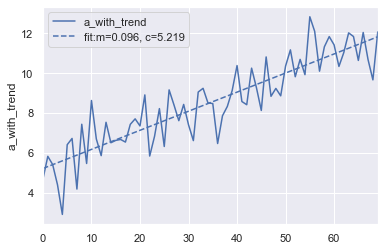

In [12]:
rand = detrend_using_func(rand,'a_with_trend',func_dtoc,'a_with_trend')

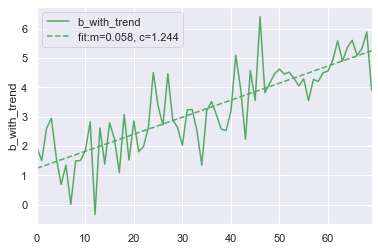

In [13]:
rand = detrend_using_func(rand,'b_with_trend',func_dtoc,'b_with_trend','g')

In [14]:
# calc correlation matrix
rand.corr('pearson').round(2)

,a,b,a_with_trend,b_with_trend,a_detrend,b_detrend
a,1.00,-0.00,0.39,-0.08,1.00,-0.02
b,-0.00,1.00,-0.19,0.40,-0.02,0.98
a_with_trend,0.39,-0.19,1.00,0.72,0.47,-0.01
b_with_trend,-0.08,0.40,0.72,1.00,-0.01,0.58
a_detrend,1.00,-0.02,0.47,-0.01,1.00,-0.02
b_detrend,-0.02,0.98,-0.01,0.58,-0.02,1.00


The pearson correlation value between the detrended time series (a_detrend & b_detrend) is found to be very small: -0.02. The value is closer to the original correlation value calculated between the time series (a & b): -0.001.

# Conclusion

We conclude it is possible that two uncorrelated time series can display pearson correlation values much higher than would otherwise be present with the presence of long term trends. 

# Plot & calculations for paper

#### Figure 1

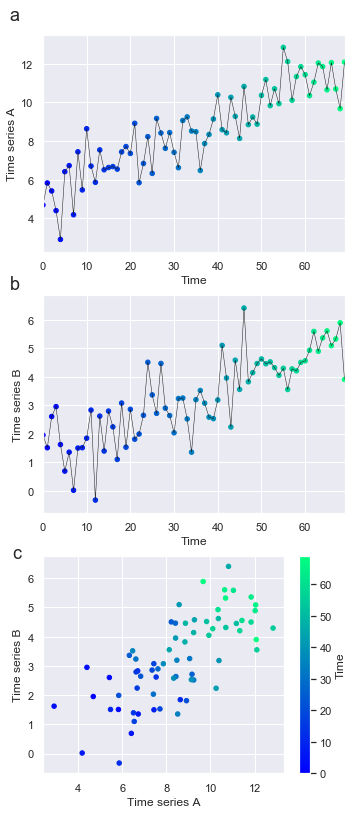

In [15]:
#### prep figure and data
fig,ax = plt.subplots(3,1,figsize=(5,11));
df = rand.copy()
df['Time'] = df.index;
df['Time series A'] = df['a_with_trend'];
df['Time series B'] = df['b_with_trend'];

#### line plots
df[['Time series A']].plot(ax=ax[0],color='k', linewidth=0.5, legend=False);
df[['Time series B']].plot(ax=ax[1],color='k', linewidth=0.5, legend=False);

#### scatter plots 
cmap='winter'
df[['Time','Time series A']].plot('Time','Time series A',kind='scatter',ax=ax[0],c='Time',colormap=cmap,colorbar=False);
df[['Time','Time series B']].plot('Time','Time series B',kind='scatter',ax=ax[1],c='Time',colormap=cmap,colorbar=False);
df[['Time series A','Time series B','Time']].plot('Time series A','Time series B',kind='scatter',ax=ax[2],c='Time',colormap=cmap);

#### plot tidying
fig.tight_layout(pad=1)

plt.text(0.9, 25.1, 'a', fontsize=18);
plt.text(0.9, 15.9, 'b', fontsize=18);
plt.text(1, 6.7, 'c', fontsize=18);

# fig.savefig('Figure1',dpi=800)

#### Ordinary least squares regression:

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['b'],df['a'])

print('R^2 value of original random data is: ', (r_value**2).round(4))

R^2 value of original random data is:  0.0


In [17]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Time series B'],df['Time series A'])

print('R^2 value of data with added linear trend is: ', (r_value**2).round(2))

R^2 value of data with added linear trend is:  0.51


In [18]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['b_detrend'],df['a_detrend'])

print('R^2 value of de-trended data is: ', (r_value**2).round(4))

R^2 value of de-trended data is:  0.0003
